In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from Utilities.get_image_data import load_data
from Utilities.form_train_val_test_batches import form_train_val_test_batches
from Utilities.NN_FC_layerwise import FCLayerwise
from Utilities.NN_FC_layerwise_new import FCLayerwise_new
from Utilities.Net import Final_Network
from Utilities.Net_new import Final_Network_ALGO_II
from Utilities.create_data import create_new
from Utilities.loss_and_accuracies import data_loss_classification, accuracy_classification
from Utilities.manifold_regularization import manifold_classification
from Utilities.manifold_regularization_new import manifold_classification_new
from Utilities.optimize_layerwise import optimize
from Utilities.additive_output import net_output 
from Utilities.plot_and_save_figures_layerwise import plot_fig
from joblib import Parallel, delayed
import multiprocessing
import random

In [2]:
from decimal import Decimal # for filenames

import pdb #Equivalent of keyboard in MATLAB, just add "pdb.set_trace()"

import os
import sys

In [3]:
###############################################################################
#                       HyperParameters and RunOptions                        #
###############################################################################
class Hyperparameters:
    max_hidden_layers = 13 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 20 
    activation        = 'relu'
    classification_act= 'linear'
    regularization    = 0.00
    manifold          = 0.00
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 900
    num_epochs        = 100
    
    num_networks      = 6
    

In [4]:
class Hyperparameters_new:
    max_hidden_layers = 3 # For this architecture, need at least 2. One for the mapping to the feature space, one as a trainable hidden layer. EXCLUDES MAPPING BACK TO DATA SPACE
    num_hidden_nodes  = 20
    activation        = 'elu'
    classification_act= 'linear'
    regularization    = 0.000
    manifold          = 0.000
    node_TOL          = 1e-4
    error_TOL         = 1e-4
    batch_size        = 1000
    num_epochs        = 50

In [5]:
class RunOptions:
    def __init__(self):    
        #=== Choose Which GPU to Use ===#
        self.which_gpu = '1'
        
        #=== Use L_1 Regularization ===#
        self.use_L1 = 1
        
        #=== Choose Data Set ===#
        self.data_MNIST = 1
        self.data_CIFAR10 = 0 
        self.data_CIFAR100 = 0
        
        #=== Random Seed ===#
        self.random_seed = 1234


In [6]:
###############################################################################
#                                 File Paths                                  #
###############################################################################         
class FilePaths():    
    def __init__(self, hyperp, run_options):  
        #=== Declaring File Name Components ===# 
        self.NN_type = 'FC'
        if run_options.data_MNIST == 1:
            self.dataset = 'MNIST'
        if run_options.data_CIFAR10 == 1:
            self.dataset = 'CIFAR10'
        if run_options.data_CIFAR100 == 1:
            self.dataset = 'CIFAR100'
        if hyperp.regularization >= 1:
            hyperp.regularization = int(hyperp.regularization)
            regularization_string = str(hyperp.regularization)
        else:
            regularization_string = str(hyperp.regularization)
            regularization_string = 'pt' + regularization_string[2:]                        
        node_TOL_string = str('%.2e' %Decimal(hyperp.node_TOL))
        node_TOL_string = node_TOL_string[-1]
        error_TOL_string = str('%.2e' %Decimal(hyperp.error_TOL))
        error_TOL_string = error_TOL_string[-1]
        
        #=== File Name ===#
        if run_options.use_L1 == 0:
            self.filename = self.dataset + '_' + self.NN_type + '_mhl%d_hl%d_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)
        else:
            self.filename = self.dataset + '_' + self.NN_type + '_L1_mhl%d_hl%d_r%s_nTOL%s_eTOL%s_b%d_e%d' %(hyperp.max_hidden_layers, hyperp.num_hidden_nodes, regularization_string, node_TOL_string, error_TOL_string, hyperp.batch_size, hyperp.num_epochs)

        #=== Saving Trained Neural Network and Tensorboard ===#
        #self.NN_savefile_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Trained_NNs/' + self.filename # Since we need to save four different types of files to save a neural network model, we need to create a new folder for each model
        self.NN_savefile_directory =  self.filename
        self.NN_savefile_name = self.NN_savefile_directory + '/' + self.filename # The file path and name for the four files
        #self.tensorboard_directory = 'C:/Users/Chandradut/Desktop/Sparse training/Tensorboard/' + self.filename

###############################################################################



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2022-04-05 19:17:08.326225: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-05 19:17:08.356321: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2593780000 Hz
2022-04-05 19:17:08.357910: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558f53c76c90 executing computations on platform Host. Devices:
2022-04-05 19:17:08.357938: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2022-04-05 19:17:08.359531: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


ListWrapper([784, 20, 20, 10])
Beginning Training
            Epoch 0            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Model: "fc_layerwise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
W2 (Dense)                   multiple                  420       
_________________________________________________________________
upsampling_layer (Dense)     multiple                  15700     
_________________________________________________________________
classification_layer (Dense) multiple                  210       
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________
Time per Batch: 0.17
Time per Epoch: 4.63

Training Set: Loss: 1.736e+00, Accuracy: 0.000
Validation Set: Loss: 9.521e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accurac

Time per Batch: 0.08
Time per Epoch: 3.98

Training Set: Loss: 2.052e-01, Accuracy: 0.000
Validation Set: Loss: 1.985e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.939

Previous Layer Relative # of 0s: 0.0000000

            Epoch 17            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.04

Training Set: Loss: 2.046e-01, Accuracy: 0.000
Validation Set: Loss: 1.970e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.942

Previous Layer Relative # of 0s: 0.0000000

            Epoch 18            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.28

Training Set: Loss: 1.987e-01, Accuracy: 0.000
Validation Set: Loss: 1.872e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.943

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 3.85

Training Set: Loss: 1.462e-01, Accuracy: 0.000
Validation Set: Loss: 1.453e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.953

Previous Layer Relative # of 0s: 0.0000000

            Epoch 36            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 3.85

Training Set: Loss: 1.441e-01, Accuracy: 0.000
Validation Set: Loss: 1.403e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.952

Previous Layer Relative # of 0s: 0.0000000

            Epoch 37            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 3.91

Training Set: Loss: 1.445e-01, Accuracy: 0.000
Validation Set: Loss: 1.387e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.953

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.05

Training Set: Loss: 1.176e-01, Accuracy: 0.000
Validation Set: Loss: 1.095e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0000000

            Epoch 55            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.00

Training Set: Loss: 1.164e-01, Accuracy: 0.000
Validation Set: Loss: 1.065e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0000000

            Epoch 56            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.02

Training Set: Loss: 1.176e-01, Accuracy: 0.000
Validation Set: Loss: 1.143e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.69

Training Set: Loss: 1.011e-01, Accuracy: 0.000
Validation Set: Loss: 9.284e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0000000

            Epoch 74            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.39

Training Set: Loss: 1.009e-01, Accuracy: 0.000
Validation Set: Loss: 9.162e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0000000

            Epoch 75            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.29

Training Set: Loss: 9.857e-02, Accuracy: 0.000
Validation Set: Loss: 9.579e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.08
Time per Epoch: 4.25

Training Set: Loss: 8.667e-02, Accuracy: 0.000
Validation Set: Loss: 8.993e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0000000

            Epoch 93            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 3.96

Training Set: Loss: 8.606e-02, Accuracy: 0.000
Validation Set: Loss: 8.212e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 94            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 2
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.15

Training Set: Loss: 8.731e-02, Accuracy: 0.000
Validation Set: Loss: 7.787e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.38

Training Set: Loss: 1.208e-01, Accuracy: 0.000
Validation Set: Loss: 1.134e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.955

Previous Layer Relative # of 0s: 0.0000000

            Epoch 9            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.22

Training Set: Loss: 1.126e-01, Accuracy: 0.000
Validation Set: Loss: 1.042e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0000000

            Epoch 10            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.09

Training Set: Loss: 1.058e-01, Accuracy: 0.000
Validation Set: Loss: 1.004e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0000000

    

Time per Batch: 0.07
Time per Epoch: 4.33

Training Set: Loss: 8.057e-02, Accuracy: 0.000
Validation Set: Loss: 7.822e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0000000

            Epoch 28            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.80

Training Set: Loss: 7.937e-02, Accuracy: 0.000
Validation Set: Loss: 7.717e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 29            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.06
Time per Epoch: 4.22

Training Set: Loss: 7.936e-02, Accuracy: 0.000
Validation Set: Loss: 7.692e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.06
Time per Epoch: 3.94

Training Set: Loss: 7.876e-02, Accuracy: 0.000
Validation Set: Loss: 7.167e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 47            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.06
Time per Epoch: 4.18

Training Set: Loss: 7.633e-02, Accuracy: 0.000
Validation Set: Loss: 8.200e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 48            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.06
Time per Epoch: 3.90

Training Set: Loss: 7.554e-02, Accuracy: 0.000
Validation Set: Loss: 7.505e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.06
Time per Epoch: 3.96

Training Set: Loss: 7.563e-02, Accuracy: 0.000
Validation Set: Loss: 7.748e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 66            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.46

Training Set: Loss: 7.633e-02, Accuracy: 0.000
Validation Set: Loss: 7.872e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 67            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.06
Time per Epoch: 4.12

Training Set: Loss: 7.376e-02, Accuracy: 0.000
Validation Set: Loss: 7.984e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.60

Training Set: Loss: 7.551e-02, Accuracy: 0.000
Validation Set: Loss: 7.509e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 85            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.15

Training Set: Loss: 7.704e-02, Accuracy: 0.000
Validation Set: Loss: 7.463e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 86            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 3
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.14

Training Set: Loss: 7.514e-02, Accuracy: 0.000
Validation Set: Loss: 7.317e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

   

Time per Epoch: 4.34

Training Set: Loss: 1.937e+00, Accuracy: 0.000
Validation Set: Loss: 1.284e+00, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.779

Previous Layer Relative # of 0s: 0.0000000

            Epoch 1            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.22

Training Set: Loss: 8.438e-01, Accuracy: 0.000
Validation Set: Loss: 5.149e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.893

Previous Layer Relative # of 0s: 0.0000000

            Epoch 2            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.10

Training Set: Loss: 3.661e-01, Accuracy: 0.000
Validation Set: Loss: 2.711e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.924

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3       

Time per Batch: 0.08
Time per Epoch: 4.33

Training Set: Loss: 8.431e-02, Accuracy: 0.000
Validation Set: Loss: 8.499e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 20            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.20

Training Set: Loss: 8.140e-02, Accuracy: 0.000
Validation Set: Loss: 8.085e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 21            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.06
Time per Epoch: 4.16

Training Set: Loss: 8.244e-02, Accuracy: 0.000
Validation Set: Loss: 8.030e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.06
Time per Epoch: 4.24

Training Set: Loss: 7.710e-02, Accuracy: 0.000
Validation Set: Loss: 8.104e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 39            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.37

Training Set: Loss: 7.619e-02, Accuracy: 0.000
Validation Set: Loss: 7.708e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 40            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.46

Training Set: Loss: 7.384e-02, Accuracy: 0.000
Validation Set: Loss: 7.854e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.70

Training Set: Loss: 7.568e-02, Accuracy: 0.000
Validation Set: Loss: 7.205e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 58            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.45

Training Set: Loss: 7.416e-02, Accuracy: 0.000
Validation Set: Loss: 7.001e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 59            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.41

Training Set: Loss: 7.550e-02, Accuracy: 0.000
Validation Set: Loss: 6.936e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.960

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.06
Time per Epoch: 4.53

Training Set: Loss: 7.347e-02, Accuracy: 0.000
Validation Set: Loss: 8.186e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 77            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.88

Training Set: Loss: 7.461e-02, Accuracy: 0.000
Validation Set: Loss: 6.920e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 78            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.39

Training Set: Loss: 7.292e-02, Accuracy: 0.000
Validation Set: Loss: 6.708e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.08
Time per Epoch: 4.58

Training Set: Loss: 7.388e-02, Accuracy: 0.000
Validation Set: Loss: 6.845e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 96            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.06
Time per Epoch: 4.44

Training Set: Loss: 7.316e-02, Accuracy: 0.000
Validation Set: Loss: 7.204e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 97            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 4
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.43

Training Set: Loss: 7.417e-02, Accuracy: 0.000
Validation Set: Loss: 7.295e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.960

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.08
Time per Epoch: 4.57

Training Set: Loss: 1.021e-01, Accuracy: 0.000
Validation Set: Loss: 1.057e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.955

Previous Layer Relative # of 0s: 0.0023810

            Epoch 12            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.75

Training Set: Loss: 9.828e-02, Accuracy: 0.000
Validation Set: Loss: 9.284e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.954

Previous Layer Relative # of 0s: 0.0023810

            Epoch 13            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 5.17

Training Set: Loss: 9.680e-02, Accuracy: 0.000
Validation Set: Loss: 9.281e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.07
Time per Epoch: 4.60

Training Set: Loss: 8.385e-02, Accuracy: 0.000
Validation Set: Loss: 8.661e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0023810

            Epoch 31            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.40

Training Set: Loss: 8.427e-02, Accuracy: 0.000
Validation Set: Loss: 7.979e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

            Epoch 32            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.06
Time per Epoch: 4.39

Training Set: Loss: 8.414e-02, Accuracy: 0.000
Validation Set: Loss: 8.088e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.06
Time per Epoch: 4.29

Training Set: Loss: 7.851e-02, Accuracy: 0.000
Validation Set: Loss: 7.647e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

            Epoch 50            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.22

Training Set: Loss: 7.867e-02, Accuracy: 0.000
Validation Set: Loss: 8.081e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

            Epoch 51            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.27

Training Set: Loss: 7.806e-02, Accuracy: 0.000
Validation Set: Loss: 7.742e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.07
Time per Epoch: 4.38

Training Set: Loss: 7.422e-02, Accuracy: 0.000
Validation Set: Loss: 7.288e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

            Epoch 69            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.44

Training Set: Loss: 7.475e-02, Accuracy: 0.000
Validation Set: Loss: 7.065e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

            Epoch 70            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.36

Training Set: Loss: 7.569e-02, Accuracy: 0.000
Validation Set: Loss: 7.155e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.07
Time per Epoch: 4.37

Training Set: Loss: 7.344e-02, Accuracy: 0.000
Validation Set: Loss: 6.947e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

            Epoch 88            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.06
Time per Epoch: 4.45

Training Set: Loss: 7.340e-02, Accuracy: 0.000
Validation Set: Loss: 7.403e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.960

Previous Layer Relative # of 0s: 0.0023810

            Epoch 89            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 5
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.22

Training Set: Loss: 7.260e-02, Accuracy: 0.000
Validation Set: Loss: 7.077e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.07
Time per Epoch: 4.68

Training Set: Loss: 4.420e-01, Accuracy: 0.000
Validation Set: Loss: 3.084e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.914

Previous Layer Relative # of 0s: 0.0000000

            Epoch 3            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.55

Training Set: Loss: 2.541e-01, Accuracy: 0.000
Validation Set: Loss: 2.047e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.932

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.50

Training Set: Loss: 1.851e-01, Accuracy: 0.000
Validation Set: Loss: 1.684e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.941

Previous Layer Relative # of 0s: 0.0000000

     

Time per Batch: 0.07
Time per Epoch: 4.76

Training Set: Loss: 8.728e-02, Accuracy: 0.000
Validation Set: Loss: 8.534e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0000000

            Epoch 22            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.68

Training Set: Loss: 8.445e-02, Accuracy: 0.000
Validation Set: Loss: 8.352e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0000000

            Epoch 23            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.50

Training Set: Loss: 8.406e-02, Accuracy: 0.000
Validation Set: Loss: 8.609e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.48

Training Set: Loss: 7.576e-02, Accuracy: 0.000
Validation Set: Loss: 7.547e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 41            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.47

Training Set: Loss: 7.680e-02, Accuracy: 0.000
Validation Set: Loss: 7.443e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 42            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.86

Training Set: Loss: 7.593e-02, Accuracy: 0.000
Validation Set: Loss: 7.667e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.49

Training Set: Loss: 7.160e-02, Accuracy: 0.000
Validation Set: Loss: 6.651e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 60            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.52

Training Set: Loss: 7.481e-02, Accuracy: 0.000
Validation Set: Loss: 7.813e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 61            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.48

Training Set: Loss: 7.135e-02, Accuracy: 0.000
Validation Set: Loss: 7.004e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.64

Training Set: Loss: 7.366e-02, Accuracy: 0.000
Validation Set: Loss: 7.613e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 79            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.69

Training Set: Loss: 7.332e-02, Accuracy: 0.000
Validation Set: Loss: 7.589e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 80            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.52

Training Set: Loss: 7.104e-02, Accuracy: 0.000
Validation Set: Loss: 7.322e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.960

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.46

Training Set: Loss: 7.319e-02, Accuracy: 0.000
Validation Set: Loss: 6.969e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 98            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.49

Training Set: Loss: 7.217e-02, Accuracy: 0.000
Validation Set: Loss: 7.189e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 99            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 6
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.48

Training Set: Loss: 7.265e-02, Accuracy: 0.000
Validation Set: Loss: 6.822e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.960

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.07
Time per Epoch: 4.65

Training Set: Loss: 9.541e-02, Accuracy: 0.000
Validation Set: Loss: 9.508e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.955

Previous Layer Relative # of 0s: 0.0119048

            Epoch 13            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.84

Training Set: Loss: 9.473e-02, Accuracy: 0.000
Validation Set: Loss: 9.187e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.955

Previous Layer Relative # of 0s: 0.0119048

            Epoch 14            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.83

Training Set: Loss: 8.983e-02, Accuracy: 0.000
Validation Set: Loss: 8.544e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.955

Previous Layer Relative # of 0s: 0.0119048

   

Time per Batch: 0.07
Time per Epoch: 4.77

Training Set: Loss: 8.143e-02, Accuracy: 0.000
Validation Set: Loss: 8.062e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0119048

            Epoch 32            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.11
Time per Epoch: 4.89

Training Set: Loss: 7.978e-02, Accuracy: 0.000
Validation Set: Loss: 7.256e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0119048

            Epoch 33            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.68

Training Set: Loss: 7.878e-02, Accuracy: 0.000
Validation Set: Loss: 7.680e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0119048

   

Time per Batch: 0.07
Time per Epoch: 4.83

Training Set: Loss: 7.505e-02, Accuracy: 0.000
Validation Set: Loss: 7.630e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0119048

            Epoch 51            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.85

Training Set: Loss: 7.510e-02, Accuracy: 0.000
Validation Set: Loss: 7.732e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0119048

            Epoch 52            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.89

Training Set: Loss: 7.375e-02, Accuracy: 0.000
Validation Set: Loss: 6.941e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0119048

   

Time per Batch: 0.07
Time per Epoch: 4.86

Training Set: Loss: 7.224e-02, Accuracy: 0.000
Validation Set: Loss: 7.104e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0119048

            Epoch 70            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.80

Training Set: Loss: 7.440e-02, Accuracy: 0.000
Validation Set: Loss: 7.743e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0119048

            Epoch 71            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.07

Training Set: Loss: 7.302e-02, Accuracy: 0.000
Validation Set: Loss: 7.648e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0119048

   

Time per Batch: 0.08
Time per Epoch: 4.65

Training Set: Loss: 7.057e-02, Accuracy: 0.000
Validation Set: Loss: 7.199e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0119048

            Epoch 89            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.63

Training Set: Loss: 7.550e-02, Accuracy: 0.000
Validation Set: Loss: 7.644e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0119048

            Epoch 90            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 7
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.63

Training Set: Loss: 7.336e-02, Accuracy: 0.000
Validation Set: Loss: 6.965e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0119048

   

Time per Batch: 0.08
Time per Epoch: 4.99

Training Set: Loss: 2.244e-01, Accuracy: 0.000
Validation Set: Loss: 1.903e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.936

Previous Layer Relative # of 0s: 0.0000000

            Epoch 4            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 4.83

Training Set: Loss: 1.768e-01, Accuracy: 0.000
Validation Set: Loss: 1.561e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.942

Previous Layer Relative # of 0s: 0.0000000

            Epoch 5            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.07
Time per Epoch: 4.97

Training Set: Loss: 1.522e-01, Accuracy: 0.000
Validation Set: Loss: 1.545e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.946

Previous Layer Relative # of 0s: 0.0000000

     

Time per Batch: 0.09
Time per Epoch: 5.87

Training Set: Loss: 8.470e-02, Accuracy: 0.000
Validation Set: Loss: 8.857e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 23            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.79

Training Set: Loss: 8.352e-02, Accuracy: 0.000
Validation Set: Loss: 8.418e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0000000

            Epoch 24            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.59

Training Set: Loss: 8.561e-02, Accuracy: 0.000
Validation Set: Loss: 8.360e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.09
Time per Epoch: 5.68

Training Set: Loss: 7.698e-02, Accuracy: 0.000
Validation Set: Loss: 7.320e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 42            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.96

Training Set: Loss: 7.717e-02, Accuracy: 0.000
Validation Set: Loss: 7.451e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 43            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.31

Training Set: Loss: 7.666e-02, Accuracy: 0.000
Validation Set: Loss: 6.881e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.09
Time per Epoch: 5.49

Training Set: Loss: 7.332e-02, Accuracy: 0.000
Validation Set: Loss: 6.838e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

            Epoch 61            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.42

Training Set: Loss: 7.285e-02, Accuracy: 0.000
Validation Set: Loss: 7.937e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 62            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.69

Training Set: Loss: 7.405e-02, Accuracy: 0.000
Validation Set: Loss: 7.023e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.12
Time per Epoch: 5.90

Training Set: Loss: 7.238e-02, Accuracy: 0.000
Validation Set: Loss: 7.045e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 80            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.52

Training Set: Loss: 7.386e-02, Accuracy: 0.000
Validation Set: Loss: 7.021e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

            Epoch 81            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.77

Training Set: Loss: 7.373e-02, Accuracy: 0.000
Validation Set: Loss: 6.854e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0000000

   

Time per Batch: 0.09
Time per Epoch: 5.64

Training Set: Loss: 7.304e-02, Accuracy: 0.000
Validation Set: Loss: 6.872e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.960

Previous Layer Relative # of 0s: 0.0000000

            Epoch 99            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 8
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.67

Training Set: Loss: 7.196e-02, Accuracy: 0.000
Validation Set: Loss: 6.676e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0000000

     Extending Architecture     
Previous Layer Relative # of 0s: 0.0023810

Beginning Training
            Epoch 0            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Model: "fc_layerwise"
_________________________________________________________________
Layer (type)                 Output Shape      

Time per Batch: 0.09
Time per Epoch: 5.76

Training Set: Loss: 1.048e-01, Accuracy: 0.000
Validation Set: Loss: 1.068e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.953

Previous Layer Relative # of 0s: 0.0023810

            Epoch 14            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.10
Time per Epoch: 5.82

Training Set: Loss: 9.960e-02, Accuracy: 0.000
Validation Set: Loss: 1.030e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.954

Previous Layer Relative # of 0s: 0.0023810

            Epoch 15            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.76

Training Set: Loss: 9.810e-02, Accuracy: 0.000
Validation Set: Loss: 9.945e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.953

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.09
Time per Epoch: 5.82

Training Set: Loss: 8.051e-02, Accuracy: 0.000
Validation Set: Loss: 8.771e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

            Epoch 33            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.76

Training Set: Loss: 8.087e-02, Accuracy: 0.000
Validation Set: Loss: 7.749e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

            Epoch 34            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.11
Time per Epoch: 6.04

Training Set: Loss: 8.073e-02, Accuracy: 0.000
Validation Set: Loss: 7.262e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.09
Time per Epoch: 5.68

Training Set: Loss: 7.590e-02, Accuracy: 0.000
Validation Set: Loss: 7.334e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

            Epoch 52            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.86

Training Set: Loss: 7.624e-02, Accuracy: 0.000
Validation Set: Loss: 7.179e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

            Epoch 53            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.10
Time per Epoch: 5.63

Training Set: Loss: 7.546e-02, Accuracy: 0.000
Validation Set: Loss: 7.800e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.09
Time per Epoch: 5.29

Training Set: Loss: 7.575e-02, Accuracy: 0.000
Validation Set: Loss: 6.799e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

            Epoch 71            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.35

Training Set: Loss: 7.418e-02, Accuracy: 0.000
Validation Set: Loss: 6.577e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

            Epoch 72            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.26

Training Set: Loss: 7.148e-02, Accuracy: 0.000
Validation Set: Loss: 6.888e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.09
Time per Epoch: 5.67

Training Set: Loss: 7.370e-02, Accuracy: 0.000
Validation Set: Loss: 7.324e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

            Epoch 90            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.66

Training Set: Loss: 7.231e-02, Accuracy: 0.000
Validation Set: Loss: 7.003e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0023810

            Epoch 91            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 9
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.59

Training Set: Loss: 7.366e-02, Accuracy: 0.000
Validation Set: Loss: 7.182e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0023810

   

Time per Batch: 0.08
Time per Epoch: 5.50

Training Set: Loss: 3.960e-01, Accuracy: 0.000
Validation Set: Loss: 3.073e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.916

Previous Layer Relative # of 0s: 0.0166667

            Epoch 4            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.39

Training Set: Loss: 2.611e-01, Accuracy: 0.000
Validation Set: Loss: 2.317e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.927

Previous Layer Relative # of 0s: 0.0166667

            Epoch 5            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.63

Training Set: Loss: 2.119e-01, Accuracy: 0.000
Validation Set: Loss: 1.900e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.933

Previous Layer Relative # of 0s: 0.0166667

   

Time per Batch: 0.08
Time per Epoch: 5.25

Training Set: Loss: 9.271e-02, Accuracy: 0.000
Validation Set: Loss: 9.120e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.955

Previous Layer Relative # of 0s: 0.0166667

            Epoch 23            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.34

Training Set: Loss: 9.476e-02, Accuracy: 0.000
Validation Set: Loss: 9.383e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0166667

            Epoch 24            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.36

Training Set: Loss: 9.040e-02, Accuracy: 0.000
Validation Set: Loss: 9.902e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0166667

 

Time per Batch: 0.08
Time per Epoch: 5.58

Training Set: Loss: 8.181e-02, Accuracy: 0.000
Validation Set: Loss: 7.851e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0166667

            Epoch 42            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.54

Training Set: Loss: 8.280e-02, Accuracy: 0.000
Validation Set: Loss: 7.839e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0166667

            Epoch 43            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.30

Training Set: Loss: 8.261e-02, Accuracy: 0.000
Validation Set: Loss: 7.701e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0166667

 

Time per Batch: 0.08
Time per Epoch: 5.41

Training Set: Loss: 7.820e-02, Accuracy: 0.000
Validation Set: Loss: 8.455e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0166667

            Epoch 61            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.52

Training Set: Loss: 7.798e-02, Accuracy: 0.000
Validation Set: Loss: 7.633e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0166667

            Epoch 62            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.45

Training Set: Loss: 7.870e-02, Accuracy: 0.000
Validation Set: Loss: 7.221e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0166667

 

Time per Batch: 0.08
Time per Epoch: 5.38

Training Set: Loss: 7.457e-02, Accuracy: 0.000
Validation Set: Loss: 7.669e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0166667

            Epoch 80            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.61

Training Set: Loss: 7.552e-02, Accuracy: 0.000
Validation Set: Loss: 7.006e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0166667

            Epoch 81            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.30

Training Set: Loss: 7.314e-02, Accuracy: 0.000
Validation Set: Loss: 7.044e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0166667

 

Time per Batch: 0.08
Time per Epoch: 5.45

Training Set: Loss: 7.350e-02, Accuracy: 0.000
Validation Set: Loss: 7.825e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0166667

            Epoch 99            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 10
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.31

Training Set: Loss: 7.234e-02, Accuracy: 0.000
Validation Set: Loss: 7.106e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0166667

     Extending Architecture     
Previous Layer Relative # of 0s: 0.0095238

Beginning Training
            Epoch 0            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Model: "fc_layerwise"
_________________________________________________________________
Layer (type)                 Output Shape    

Time per Batch: 0.08
Time per Epoch: 5.41

Training Set: Loss: 1.097e-01, Accuracy: 0.000
Validation Set: Loss: 1.126e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.954

Previous Layer Relative # of 0s: 0.0095238

            Epoch 13            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.42

Training Set: Loss: 1.029e-01, Accuracy: 0.000
Validation Set: Loss: 1.014e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.955

Previous Layer Relative # of 0s: 0.0095238

            Epoch 14            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.80

Training Set: Loss: 1.030e-01, Accuracy: 0.000
Validation Set: Loss: 9.665e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0095238

 

Time per Batch: 0.09
Time per Epoch: 5.72

Training Set: Loss: 8.405e-02, Accuracy: 0.000
Validation Set: Loss: 8.617e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0095238

            Epoch 32            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.35

Training Set: Loss: 8.300e-02, Accuracy: 0.000
Validation Set: Loss: 8.471e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

            Epoch 33            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.44

Training Set: Loss: 8.123e-02, Accuracy: 0.000
Validation Set: Loss: 8.184e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

 

Time per Batch: 0.09
Time per Epoch: 5.43

Training Set: Loss: 8.250e-02, Accuracy: 0.000
Validation Set: Loss: 8.435e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0095238

            Epoch 51            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.62

Training Set: Loss: 8.081e-02, Accuracy: 0.000
Validation Set: Loss: 8.219e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0095238

            Epoch 52            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.43

Training Set: Loss: 8.144e-02, Accuracy: 0.000
Validation Set: Loss: 7.525e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

 

Time per Batch: 0.10
Time per Epoch: 5.69

Training Set: Loss: 7.660e-02, Accuracy: 0.000
Validation Set: Loss: 8.201e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0095238

            Epoch 70            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.67

Training Set: Loss: 7.799e-02, Accuracy: 0.000
Validation Set: Loss: 8.314e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

            Epoch 71            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.42

Training Set: Loss: 7.876e-02, Accuracy: 0.000
Validation Set: Loss: 7.308e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0095238

 

Time per Batch: 0.10
Time per Epoch: 5.69

Training Set: Loss: 7.758e-02, Accuracy: 0.000
Validation Set: Loss: 7.759e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

            Epoch 89            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.63

Training Set: Loss: 7.653e-02, Accuracy: 0.000
Validation Set: Loss: 7.278e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

            Epoch 90            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 11
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.10
Time per Epoch: 5.56

Training Set: Loss: 7.433e-02, Accuracy: 0.000
Validation Set: Loss: 7.763e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

 

Time per Batch: 0.09
Time per Epoch: 5.73

Training Set: Loss: 6.465e-01, Accuracy: 0.000
Validation Set: Loss: 4.354e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.909

Previous Layer Relative # of 0s: 0.0095238

            Epoch 3            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.87

Training Set: Loss: 3.298e-01, Accuracy: 0.000
Validation Set: Loss: 2.481e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.929

Previous Layer Relative # of 0s: 0.0095238

            Epoch 4            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.98

Training Set: Loss: 2.125e-01, Accuracy: 0.000
Validation Set: Loss: 1.746e-01, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.940

Previous Layer Relative # of 0s: 0.0095238

   

Time per Batch: 0.10
Time per Epoch: 5.85

Training Set: Loss: 9.672e-02, Accuracy: 0.000
Validation Set: Loss: 9.268e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0095238

            Epoch 22            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.87

Training Set: Loss: 9.312e-02, Accuracy: 0.000
Validation Set: Loss: 8.768e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.956

Previous Layer Relative # of 0s: 0.0095238

            Epoch 23            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.66

Training Set: Loss: 9.231e-02, Accuracy: 0.000
Validation Set: Loss: 9.996e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.955

Previous Layer Relative # of 0s: 0.0095238

 

Time per Batch: 0.09
Time per Epoch: 6.04

Training Set: Loss: 8.221e-02, Accuracy: 0.000
Validation Set: Loss: 8.484e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0095238

            Epoch 41            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.90

Training Set: Loss: 8.188e-02, Accuracy: 0.000
Validation Set: Loss: 8.595e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0095238

            Epoch 42            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.10
Time per Epoch: 6.91

Training Set: Loss: 8.501e-02, Accuracy: 0.000
Validation Set: Loss: 7.981e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.957

Previous Layer Relative # of 0s: 0.0095238

 

Time per Batch: 0.09
Time per Epoch: 5.81

Training Set: Loss: 7.806e-02, Accuracy: 0.000
Validation Set: Loss: 7.854e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0095238

            Epoch 60            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.88

Training Set: Loss: 7.862e-02, Accuracy: 0.000
Validation Set: Loss: 7.948e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

            Epoch 61            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.71

Training Set: Loss: 7.966e-02, Accuracy: 0.000
Validation Set: Loss: 7.923e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

 

Time per Batch: 0.10
Time per Epoch: 5.76

Training Set: Loss: 7.644e-02, Accuracy: 0.000
Validation Set: Loss: 7.216e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.958

Previous Layer Relative # of 0s: 0.0095238

            Epoch 79            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.08
Time per Epoch: 5.64

Training Set: Loss: 7.517e-02, Accuracy: 0.000
Validation Set: Loss: 7.794e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

            Epoch 80            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 5.71

Training Set: Loss: 7.490e-02, Accuracy: 0.000
Validation Set: Loss: 7.382e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

 

Time per Batch: 0.09
Time per Epoch: 5.73

Training Set: Loss: 7.482e-02, Accuracy: 0.000
Validation Set: Loss: 7.702e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

            Epoch 98            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 6.02

Training Set: Loss: 7.490e-02, Accuracy: 0.000
Validation Set: Loss: 6.897e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

            Epoch 99            
MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100
Trainable Hidden Layer Index: 12
GPU: 1

Optimizing 54 batches of size 900:
Time per Batch: 0.09
Time per Epoch: 6.09

Training Set: Loss: 7.507e-02, Accuracy: 0.000
Validation Set: Loss: 7.196e-02, Accuracy: 0.000
Test Set: Loss: 0.000e+00, Accuracy: 0.959

Previous Layer Relative # of 0s: 0.0095238

 

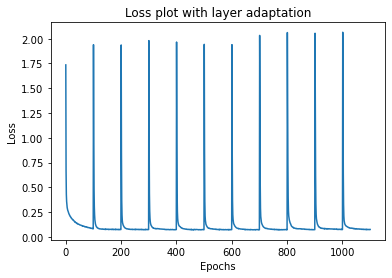

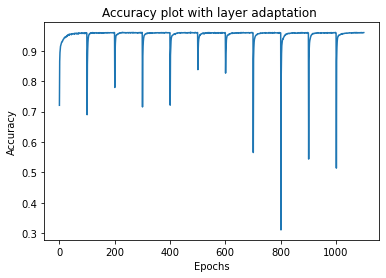

In [7]:
if __name__ == "__main__":     

    #=== Hyperparameters and Run Options ===#    
    hyperp = Hyperparameters()
    hyperp_new=Hyperparameters_new()
    run_options = RunOptions()
    

    #=== File Names ===#
    file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       
    data_train, labels_train,\
    data_test, labels_test,\
    data_input_shape, num_channels, label_dimensions\
    = load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed) 
    


    
    #for i in range(1,hyperp.num_networks):
    for i in range(1,2):
    #=== Initiate training ===#
        #trainer(hyperp, run_options, file_paths,i) 
        

    
            
        
        
        
        
            #=== GPU Settings ===#
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
        os.environ["CUDA_VISIBLE_DEVICES"] = run_options.which_gpu
    
            #=== Neural Network ===#
        if run_options.use_L1 == 0:
            kernel_regularizer = None
            bias_regularizer = None  
        else:
            kernel_regularizer = tf.keras.regularizers.l1(hyperp.regularization)
            bias_regularizer = tf.keras.regularizers.l1(hyperp.regularization)

        data_train,new_label,labels_train=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,i)
        
        #=== Construct Validation Set and Batches ===# 
        data_and_labels_train, data_and_labels_val, data_and_labels_test,\
        num_data_train, num_data_val, num_data_test,\
        num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
        = form_train_val_test_batches(data_train, labels_train, \
                                  data_test, labels_test, \
                                  hyperp.batch_size, new_label, run_options.random_seed)
        
        
        if i==1:
            NN = FCLayerwise(hyperp, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer)    
        if i>1:
            kernel_regularizer = None
            bias_regularizer = None
            NN = FCLayerwise_new(hyperp_new, run_options, data_input_shape, label_dimensions,kernel_regularizer, bias_regularizer) 
    
    #=== Training ===#
    #                                 Training                                    #
###############################################################################

        if i==1:
            hyperp_n=hyperp
            optimize(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, accuracy_classification, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape)   
        
        if i>1:
            hyperp_n=Hyperparameters_new()
            optimize(hyperp,hyperp_n, run_options, file_paths, NN, data_loss_classification, accuracy_classification, data_and_labels_train, data_and_labels_val, data_and_labels_test, label_dimensions, num_batches_train,data_and_labels_train_new,manifold_classification_new,hyperp.batch_size,run_options.random_seed,num_data_train,i,data_input_shape)   
        
        
        
        if i==1:
            plot_fig(hyperp, run_options, file_paths,i)
            
        if i>1:
            plot_fig(hyperp_new, run_options, file_paths,i)
        
        

        
        
        
        
        
        
        
        

In [8]:
    import matplotlib.pyplot as plt
    storage_loss_array=[]
    storage_accuracy_array=[]
    max_hidden_layers=hyperp.max_hidden_layers
    no_epoch=hyperp.num_epochs
    i_val=1
    for i in range(2,8):
    
        trainable_hidden_layer_index=i
    
    
        name=file_paths.NN_savefile_name + "_metrics_hl" + str(trainable_hidden_layer_index) +str(1)+ '.csv'


        df_metrics =pd.read_csv(name)

        array_metrics = df_metrics.to_numpy()

        storage_loss_array=np.concatenate((storage_loss_array, array_metrics[:,0]), axis=0)
 
        storage_accuracy_array=np.concatenate((storage_accuracy_array, array_metrics[:,1]), axis=0)
    
    if not os.path.exists("plots"):
        os.makedirs("plots")
#=== Plot and Save Losses===#
    fig_loss = plt.figure()
    x_axis = np.linspace(1, len(storage_loss_array), len(storage_loss_array), endpoint = True)
    plt.plot(x_axis, storage_loss_array)
    plt.title('Loss plot with layer adaptation' )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    fig_loss.savefig("plots"+'/'+"loss"+str(i_val)+'.png')

    

#=== Plot and Save Accuracies===#
    fig_accuracy = plt.figure()
    x_axis = np.linspace(1, len(storage_accuracy_array), len(storage_accuracy_array), endpoint = True)
    plt.plot(x_axis, storage_accuracy_array)
#plt.title('Accuracy for: ' + run_options.filename)
    plt.title('Accuracy plot with layer adaptation ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    fig_accuracy.savefig("plots"+'/'+"accuracy"+str(i_val)+'.png')

FileNotFoundError: [Errno 2] No such file or directory: 'MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100/MNIST_FC_L1_mhl13_hl20_rpt0_nTOL4_eTOL4_b900_e100_metrics_hl21.csv'

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

hyperp = Hyperparameters()
hyperp_new=Hyperparameters_new()
run_options = RunOptions()
    

    #=== File Names ===#
file_paths = FilePaths(hyperp, run_options)
    
    #=== Load Data ===#       

data_train, labels_train,\
data_test, labels_test,\
data_input_shape, num_channels, label_dimensions\
= load_data(file_paths.NN_type, file_paths.dataset, run_options.random_seed)    
    
model = keras.Sequential()
model.add(layers.Dense(20, activation='elu', input_shape=(784,)))
model.add(layers.Dense(20, activation='elu'))
model.add(layers.Dense(20, activation='elu'))
model.add(layers.Dense(20, activation='elu'))
model.add(layers.Dense(20, activation='elu'))
model.add(layers.Dense(20, activation='elu'))
model.add(layers.Dense(20, activation='elu'))
model.add(layers.Dense(20, activation='elu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()



opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(data_train,labels_train,batch_size=1000,epochs=100,verbose=1)
    
batch_pred_test = model(data_test)
mean_accuracy_test = tf.keras.metrics.Mean()
            
mean_accuracy_test(accuracy_classification(batch_pred_test, labels_test))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 20)                15700     
_________________________________________________________________
dense_55 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_56 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_57 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_58 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_59 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_60 (Dense)             (None, 20)               

<tf.Tensor: id=57799, shape=(), dtype=float32, numpy=0.9581>

In [19]:
        data_train,new_label,labels_train=create_new(data_train, labels_train,hyperp,hyperp_new, run_options, data_input_shape, label_dimensions,1)
        
        #=== Construct Validation Set and Batches ===# 
        data_and_labels_train, data_and_labels_val, data_and_labels_test,\
        num_data_train, num_data_val, num_data_test,\
        num_batches_train, num_batches_val, num_batches_test,data_and_labels_train_new\
        = form_train_val_test_batches(data_train, labels_train, \
                                  data_test, labels_test, \
                                  hyperp.batch_size, new_label, run_options.random_seed)


In [20]:
for batch_num_num, (batch_data_val, batch_labels_val,labels_val) in data_and_labels_val.enumerate():
    batch_data_val

In [24]:
data_train

<tf.Tensor: id=55, shape=(60000, 784), dtype=float32, numpy=
array([[-0.44079024, -0.44079024, -0.44079024, ..., -0.44079024,
        -0.44079024, -0.44079024],
       [-0.47280213, -0.47280213, -0.47280213, ..., -0.47280213,
        -0.47280213, -0.47280213],
       [-0.37816134, -0.37816134, -0.37816134, ..., -0.37816134,
        -0.37816134, -0.37816134],
       ...,
       [-0.39482278, -0.39482278, -0.39482278, ..., -0.39482278,
        -0.39482278, -0.39482278],
       [-0.39232355, -0.39232355, -0.39232355, ..., -0.39232355,
        -0.39232355, -0.39232355],
       [-0.39491966, -0.39491966, -0.39491966, ..., -0.39491966,
        -0.39491966, -0.39491966]], dtype=float32)>

In [18]:
new=batch_data_val

In [21]:
tf.norm(batch_data_val-new)

<tf.Tensor: id=987, shape=(), dtype=float32, numpy=0.0>

In [28]:
labels_train=np.squeeze(labels_train,axis=1)

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

In [8]:
Network=Final_Network(hyperp, run_options, data_input_shape, label_dimensions,
                      kernel_regularizer, bias_regularizer) 

ListWrapper([28, 10, 10, 10])


In [9]:
Network.load_weights("WEIGHTS"+'/'+"model_weights1")

In [12]:
data_and_labels_train

<BatchDataset shapes: ((None, 784), (None,), (None, 10)), types: (tf.float32, tf.int32, tf.float32)>

In [37]:
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train.enumerate():
    r[batch_num]=batch_data_train
    

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

TypeError: 'DatasetV1Adapter' object does not support indexing

In [33]:
data_and_labels_train_new = data_train.take(num_data_train)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'take'

In [10]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_test = tf.data.Dataset.from_tensor_slices((data_test, labels_test)).batch(batch_size)
num_batches_test = len(list(data_and_labels_test))

#=== Partitioning Out Validation Set and Constructing Batches ===#
current_num_data_train = num_data_train
num_data_train = int(0.8 * num_data_train)
num_data_val = current_num_data_train - num_data_train
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).shuffle(num_data_train, seed=random_seed)
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [23]:
(data_train, labels_train), (data_test, labels_test) = datasets.mnist.load_data()
data_train = data_train.reshape(data_train.shape[0], 28, 28, 1)
data_test = data_test.reshape(data_test.shape[0], 28, 28, 1)
label_dimensions = 10
data_input_shape = data_train.shape[1:]

#=== Casting as float32 ===#
data_train = tf.cast(data_train,tf.float32)
labels_train = tf.cast(labels_train, tf.int32)
data_test = tf.cast(data_test, tf.float32)
labels_test = tf.cast(labels_test, tf.int32)
    
#=== Normalize Data ===#
data_train, data_test = data_train/255.0, data_test/255.0
data_train = tf.image.per_image_standardization(data_train) # Linearly scales each image to have mean 0 and variance 1
data_test = tf.image.per_image_standardization(data_test)   # Linearly scales each image to have mean 0 and variance 1

data_train = tf.reshape(data_train, (len(data_train), 28*28))
data_test = tf.reshape(data_test, (len(data_test), 28*28))

num_data_train = len(data_train)
num_data_test = len(data_test)
random_seed=1234
batch_size        = 1000

In [24]:
labels=tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [25]:
data_and_labels_train_full = tf.data.Dataset.from_tensor_slices((data_train, labels_train,labels)).shuffle(num_data_train, seed=random_seed)

In [26]:
data_and_labels_train = data_and_labels_train_full.take(num_data_train).batch(batch_size)
data_and_labels_val = data_and_labels_train_full.skip(num_data_train).batch(batch_size)    
num_batches_train = len(list(data_and_labels_train))
num_batches_val = len(list(data_and_labels_val))

In [32]:
for batch_num, (batch_data_train, batch_labels_train,labels) in data_and_labels_train.enumerate():
    batch=batch_num
    batch_data_train = batch_data_train
    batch_labels_train=batch_labels_train
    lab=labels

In [36]:
lab


<tf.Tensor: shape=(1000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [20]:
y_true = tf.one_hot(tf.cast(labels_train,tf.int64), label_dimensions, dtype=tf.float32)

In [21]:
y_true

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [37]:
np.mean(tf.keras.losses.mean_squared_error(new_one, val[0:dimension[0]-1]))

1.9269863

array([4, 6, 6, ..., 7, 2, 5])

In [19]:

x_train_new = batch_data_train[batch_labels_train == 1]
batch_pred_train,val=NN(x_train_new)



In [16]:
y_true = tf.one_hot(tf.cast(y_true,tf.int64), label_dimensions, dtype=tf.float32)

In [45]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.6097095>

In [48]:
np.linalg.norm(val[0]-val[1])

2.567157